## Como usar?
#### só executar

In [1]:
using DelimitedFiles
using LinearAlgebra
using ForwardDiff
using Plots

## Function Definitions

In [2]:
# Data Type Format
#=
1.1 - name          <- Function name
2.1 - data          <- Data Matrix
3.1 - npts          <- Num. of points per sample 
4.1 - nout          <-
5.1 - model         <- Model function
6.1 - dim           <- Num. of parameters
7.1 - cluster       <-
8.1 - noise         <-
9.1 - solution      <- Vector Solution
10.1 - description  <-
=#

"""
Goal: 

#### Input:

#### Output:

"""
struct sample_type
    name::String
    data::Array{Float64,2}
    n::Int64
    dim::Int64
    model::Function
    solution::Vector{Float64}
end

"""
Goal: 

#### Input:

#### Output:

"""
function sample_parsing(file::String)
    data_sample = readdlm(file, ':')
    return sample_type(
                      data_sample[1,2],                   # name
                      eval(Meta.parse(data_sample[2,2])), # matrix
                      data_sample[3,2],                   # num pts
                      data_sample[6,2],                   # num parameters
                      eval(Meta.parse(data_sample[5,2])), # function
                      eval(Meta.parse(data_sample[9,2])), # solution
                      )
end

"""
Goal: 

#### Input:

#### Output:

"""
function dumping(f,R,J,dp::String)  
    DP1 = (norm(J'*R)^2)/(0.5*norm(R)^2)
    DP2 = norm(J'*R)^2
    DP3 = norm(J'*R)^2
    DP4 = 2*f
    DP4 = sqrt(2*f)
    #DP5 = (2*norm(J'*R)/(3*k)
    
    if dp=="DP1"
        return DP1
    elseif dp=="DP2"
        return DP2
    elseif dp=="DP3"
        return DP3
    elseif dp=="DP4"
        return DP4
    #elseif dp=="DP5"
    #    return DP5
    end
end

function Residual(A, t, n, dim, f)
    R = zeros(n)
    for i = 1 : n  
        R[i] = A[i,2]-f(A[i,1],t)
    end
    return R
end

"""
Goal: computes the Jacobian Matrix

#### Input:
     A - data matrix
     t - initial vector
     n - number of observations
     dim - dimension of model
     f - model to fit

#### Output:
     J - jacobian matrix
"""
function Jacobian(A, t, n, dim, f)
    J = zeros(n,dim)
    for i = 1:n
        r(t) = A[i,2]-f(A[i,1],t)
        J[i, :] = ForwardDiff.gradient(r,t)
    end
    return J
end


"""
Goal: 

#### Input:
     A - data matrix
     f - model function
     t - initial estimation
     dim - dim
     n - n
     lamb - Dumping parameter, may be a String or a Float
            if String: {}

#### Output:
     J - jacobian matrix
"""
function LM_dumping(A, f, t, dim::Int, n::Int, lamb=0.5, eps = 1.0e-9, itmax=1000)
    
    k = 0
    R = Residual(A,t,n,dim,f)
    J = Jacobian(A,t,n,dim,f)
    
    while norm(J'*R) > eps  && k < itmax
        
        if typeof(lamb)==String
            lamb = dumping(0.5*norm(R)^2,R,J,lamb)
        end
        # Verificar se o lambda esta alterando?
        
        M = J'*J + lamb*I
        d = M\(-J'*R)
        a = 1.0
        
        R_temp = Residual(A, t + a*d, n,dim,f)
        l = 0
        while 0.5*norm(R_temp)^2 > 0.5*norm(R)^2 + 0.5*a*(J'*R)'*d && l < itmax
            a = 0.5*a
            l = l +1
        end
        
        t = t +a*d
        k = k + 1
        
        R = Residual(A,t,n,dim,f)
        J = Jacobian(A,t,n,dim,f)
    end
    return t, k
end

LM_dumping

## Testing
#### cleaning - para ver se o algoritmo esta correto

In [4]:
sample_test = sample_parsing("./problems-csv/parabola/parabola_-5.5_0.0_1.0_150_38.csv")

name = sample_test.name
A = sample_test.data
n = sample_test.n
dim = sample_test.dim
func = sample_test.model
sol = sample_test.solution


function cleaning(A, t, f)
    k = 0
    n, m = size(A)
    for i = 1:n
        if abs(A[i,2] - f(A[i,1],t)) < 1.0e-8 && abs(A[i,1]) > 1.0e-8  && abs(A[i,2]) > 1.0e-8
            k = k + 1
        end
    end
    
    M = zeros(k, m)
    d = 1
    for j = 1: n 
        if abs(A[j,2] - f(A[j,1],t)) < 1.0e-8 && abs(A[j,1]) > 1.0e-8  && abs(A[j,2]) > 1.0e-8
            M[d,:] = A[j,:]
            d = d + 1        
        end
    end
    return M
end

M = cleaning(A, sol, func)
LM_dumping(M, func, [0,0,0], dim, size(M)[1], "DP1")

([-5.499999999988416, 1.0316968168902018e-12, 0.9999999999766127], 546)

## Exemplo de Função que passa por todos os arquivos
#### Quando encapsulo em uma função, não da certo. Não sei pq. Acho que tem algo a ver com o Struct...

In [9]:
"""
Goal: 

#### Input:
     model_string::String:: {parabola|cubic|gaussian|log}

#### Output:
"""
function LM_dumping_allfiles(model_string::String)
    dir_path = "./problems-csv/"*model_string*"/"
    filelist = readdir(dir_path)

    #for i=1:size(filelist)[1]
    for i=1:3    
        sample_test = sample_parsing(dir_path*filelist[i])

        name = sample_test.name
        A = sample_test.data
        n = sample_test.n
        dim = sample_test.dim
        func = sample_test.model
        sol = sample_test.solution
        
        #M = cleaning(A, sol, func)
        #LM_dumping(M, func, sol, dim, size(M)[1], "DP1")
    end
end
    
LM_dumping_allfiles("log")

#### Assim, sem ser em função, da certo

In [8]:
# Nome do modelo
model_string="parabola"

# Estimativa inicial
aproximations = [0.0,0.0,0.0]

# Caminhos dos diretórios
dir_path = "./problems-csv/"*model_string*"/"
filelist = readdir(dir_path)

# Número de arquivos
num_files = size(filelist)[1]

# Contador de iterações
iteractions = 0

for i=1:100 # Aqui trocar para num_files depois de retirar os arquivos quebrados
    sample_test = sample_parsing(dir_path*filelist[i])

    name = sample_test.name
    A = sample_test.data
    n = sample_test.n
    dim = sample_test.dim
    func = sample_test.model
    sol = sample_test.solution
        
    #M = cleaning(A, sol, func)
    #LM_dumping(M, func, sol, dim, size(M)[1], "DP1")
    
    t, k = LM_dumping(A, func, sol, dim, n, "DP1")
    iteractions += k
    aproximations += t
end

println("Número médio de iterações: ", iteractions/num_files)
println("Valor médio da solução: ", aproximations/num_files)

Número médio de iterações: 290.9125475285171
Valor médio da solução: [-0.9631500739573777, 0.1391566194935552, -0.5512516411233508]


## Ploting

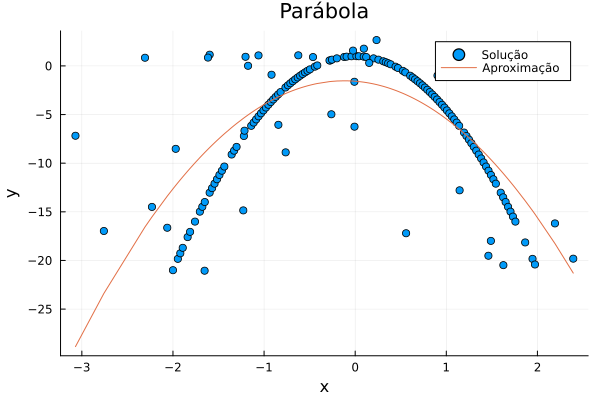

In [6]:
sample_test = sample_parsing("./problems-csv/parabola/parabola_-5.5_0.0_1.0_150_38.csv")

name = sample_test.name
A = sample_test.data
n = sample_test.n
dim = sample_test.dim
func = sample_test.model
sol = sample_test.solution

aprox_solution, w = LM_dumping(A, func, [0.0, 0.0, 0.0], dim, n, "DP1")

function plotting(A, aprox_solution, title::String)
    aprox_matrix = copy(A)

    for i=1:n
        aprox_matrix[i,2] = func(A[i,1], aprox_solution)
    end

    # Ordenação de acordo com a coluna 1
    aprox_matrix = aprox_matrix[sortperm(aprox_matrix[:,1]),:]
    
    # Plotando pontos da solução exata
    scatter(A[:,1],A[:,2], title=title, label="Solução")
    # Plotando curva da solução aproximada
    plot!(aprox_matrix[:,1],aprox_matrix[:,2], label="Aproximação")
    xlabel!("x")
    ylabel!("y")   
end

plotting(A, aprox_solution, "Parábola")